### Data Extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import librosa as lb
import pywt


!pip install wfdb
import wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
!unzip /content/drive/MyDrive/voiced-database-1.0.0.zip #run after mounting google drive

Archive:  /content/drive/MyDrive/voiced-database-1.0.0.zip
 extracting: voice-icar-federico-ii-database-1.0.0/voice130.txt  
 extracting: voice-icar-federico-ii-database-1.0.0/voice174.hea  
 extracting: voice-icar-federico-ii-database-1.0.0/voice022.hea  
 extracting: voice-icar-federico-ii-database-1.0.0/voice157.txt  
 extracting: voice-icar-federico-ii-database-1.0.0/voice172.hea  
 extracting: voice-icar-federico-ii-database-1.0.0/voice102.hea  
 extracting: voice-icar-federico-ii-database-1.0.0/voice168-info.txt  
 extracting: voice-icar-federico-ii-database-1.0.0/voice053.txt  
 extracting: voice-icar-federico-ii-database-1.0.0/voice006.txt  
 extracting: voice-icar-federico-ii-database-1.0.0/voice163.dat  
 extracting: voice-icar-federico-ii-database-1.0.0/voice115.dat  
 extracting: voice-icar-federico-ii-database-1.0.0/voice044.hea  
 extracting: voice-icar-federico-ii-database-1.0.0/voice200.dat  
 extracting: voice-icar-federico-ii-database-1.0.0/voice028-info.txt  
 extrac

<function matplotlib.pyplot.show(close=None, block=None)>

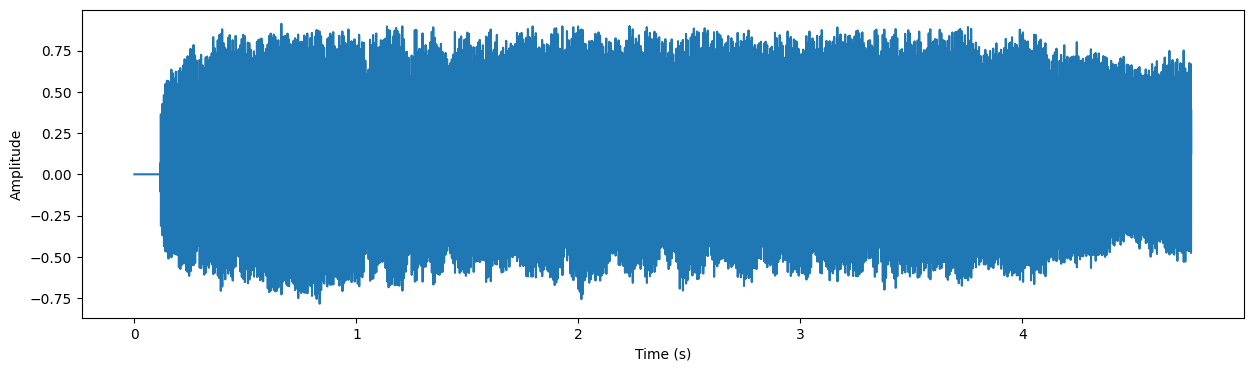

In [ ]:
voice_1 = wfdb.rdrecord('/content/voice-icar-federico-ii-database-1.0.0/voice095')
#wfdb.plot_wfdb(record=voice_1)
#display(voice_1.__dict__)
segment = voice_1.p_signal
segment = segment[:,0]
time = np.arange(0,len(segment))/(voice_1.fs)
plt.figure(figsize=(15,4))
plt.plot(time, segment)
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

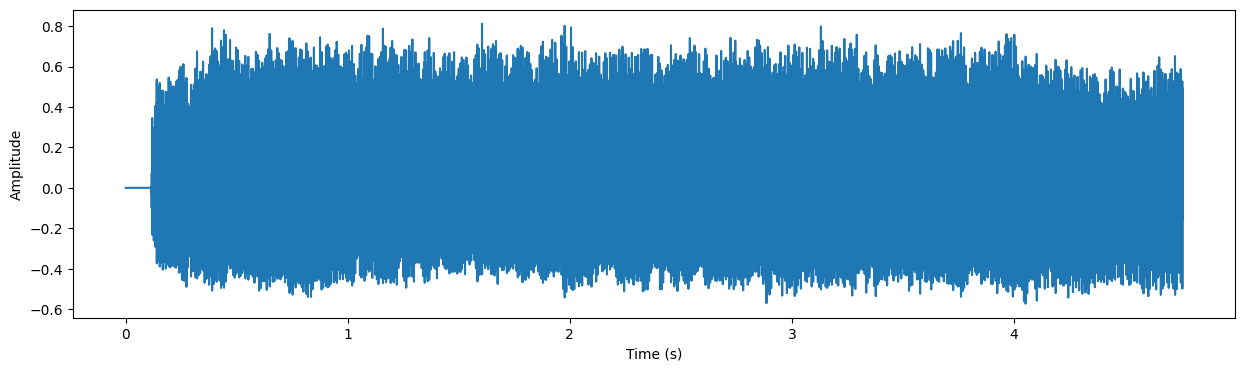

In [ ]:
pre_emph_coeff = 0.90
emphasized_signal = np.append(segment[0], segment[1:] - pre_emph_coeff * segment[:-1])
new_time = np.arange(0, len(emphasized_signal))/(voice_1.fs)
plt.figure(figsize=(15,4))
plt.plot(new_time, emphasized_signal)
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.show

### Frames for conversion of transforms

In [ ]:
frame_size = 0.025
frame_stride = 0.01
frame_length, frame_step = frame_size * (voice_1.fs), frame_stride * (voice_1.fs)
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [ ]:
# passing each frame through hamming window
frames *= np.hamming(frame_length)

### Mel Filter Bank

In [ ]:
melfb = lb.filters.mel(sr = voice_1.fs, n_fft=1024, fmax=8000)

<ipython-input-8-8da10575aaa1>:1: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  melfb = lb.filters.mel(sr = voice_1.fs, n_fft=1024, fmax=8000)


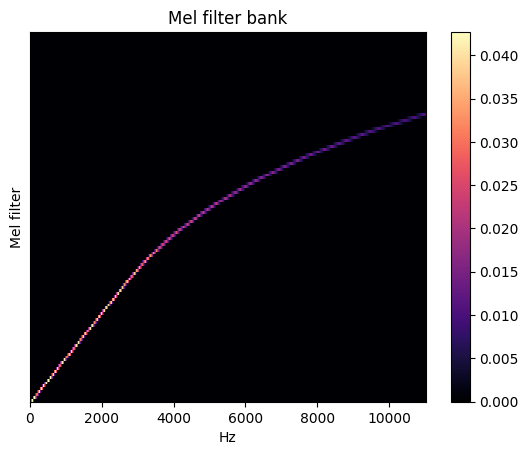

In [ ]:
fig, ax = plt.subplots()
img = lb.display.specshow(melfb, x_axis='linear', ax=ax)
ax.set(ylabel='Mel filter', title='Mel filter bank')
fig.colorbar(img, ax=ax)

### Mel Spectogram

In [ ]:
mels = lb.feature.melspectrogram(y=segment, sr=voice_1.fs, n_mels=1024, fmax=8000)

/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [ ]:
mels_db = lb.power_to_db(mels, ref=np.max)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

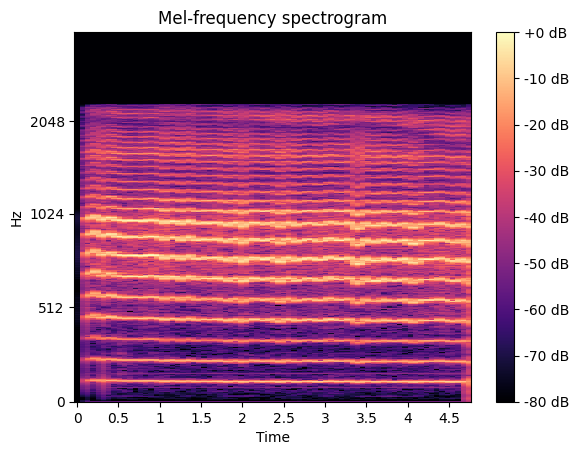

In [ ]:
fig, ax = plt.subplots()
img = lb.display.specshow(mels_db, x_axis = 'time', y_axis='mel', sr=voice_1.fs, fmax=voice_1.fs/2, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

### MFCC

In [ ]:
mfcc = lb.feature.mfcc(y=segment, sr=voice_1.fs, n_mfcc=13)

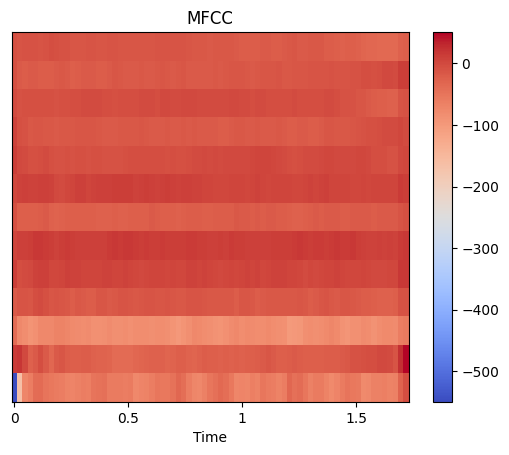

In [ ]:
fig, ax = plt.subplots()
img = lb.display.specshow(mfcc, x_axis='time')
ax.set(title='MFCC')
fig.colorbar(img, ax=ax)

### Chirplet Transform

In [ ]:
chirplet = lb.cqt(segment)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


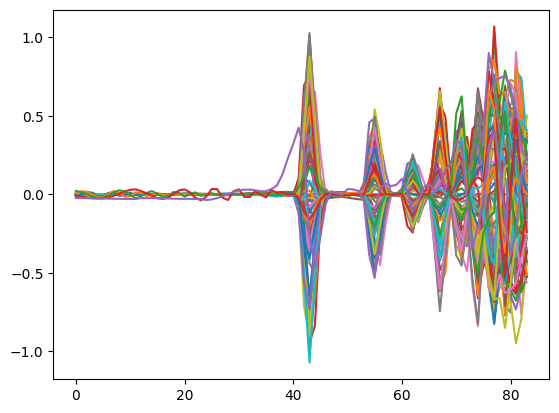

In [ ]:
plt.figure()
plt.plot(chirplet)
plt.show()

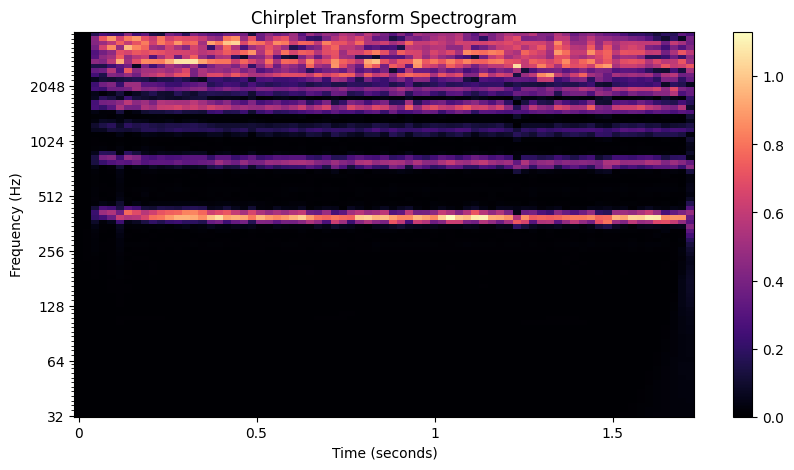

In [ ]:
frequencies = lb.cqt_frequencies(n_bins=512, fmin = 0)


plt.figure(figsize=(10, 5))
lb.display.specshow(np.abs(chirplet), x_axis="time", y_axis="cqt_hz")
plt.title("Chirplet Transform Spectrogram")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.colorbar()
plt.show()

### Fourier Transform

In [ ]:
fourier = lb.stft(segment, n_fft=1024, hop_length=256)  # STFT of y
S_db = lb.amplitude_to_db(np.abs(fourier), ref=np.max)

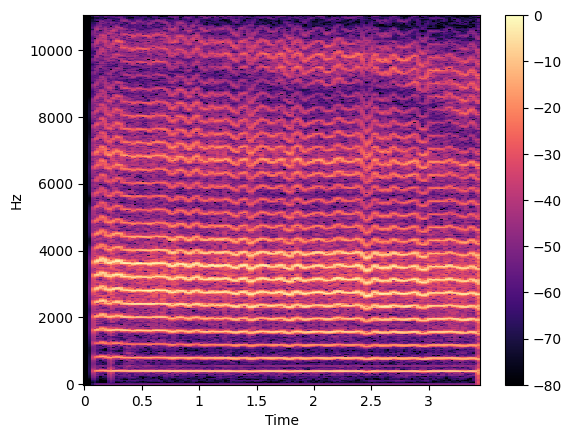

In [ ]:
plt.figure()
lb.display.specshow(S_db, x_axis="time", y_axis="fft")
plt.colorbar()

###